<a href="https://colab.research.google.com/github/WistonTravieso/DS-Algorithm-optimization-project-machine-learning/blob/main/src/exploring-time-series.es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Paso 1. Lectura del conjunto de datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
url = "https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv"

In [3]:
total_data = pd.read_csv(url)
total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [6]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [17]:
total_data["date"] = pd.to_datetime(total_data["date"])
total_data.info()
ts = total_data.set_index('date')['sales']
total_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   sales   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633


A continuación visualizaremos la serie temporal para llevar a cabo un análisis visual de la misma:

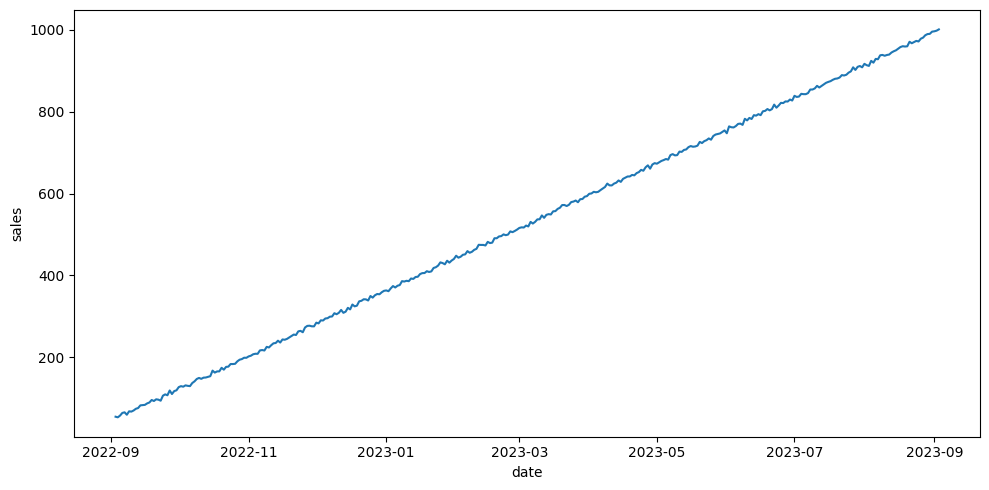

In [19]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

### Paso 2. Análisis de una serie temporal

Para analizar una serie temporal, como vimos en la teoría, debemos estudiar varios parámetros:

- **Tendencia**
- **Estacionalidad**
- **Variabilidad**
- **Puntos atípicos** (*Outliers*)
- **Puntos de inflexión**

A través de un análisis visual podríamos ser capaces de estimar estas métricas a ojo, pero siempre es mejor orientar el análisis a los datos matemáticos. Para la labor de realizar predicciones sobre series temporales y analizarlas, nos apoyaremos en la librería `statsmodels`:

#### Descomposición de la serie

La descomposición de una serie temporal es un proceso estadístico que separa de una serie de tiempo en varios elementos diferenciados. Cada uno de estos componentes representa una parte de la estructura subyacente de la serie temporal. La descomposición de una serie de tiempo puede ser muy útil para entender mejor los datos y tomar decisiones informadas al construir modelos de pronóstico.

Utilizamos la función `seasonal_decompose` de la biblioteca `statsmodels` para descomponer la serie de tiempo en sus componentes de tendencia, estacionalidad y residuos.

#### Análisis de la tendencia

La tendencia se refiere a la dirección general en la que se mueven los datos. Para acceder a su información recurrimos al componente `trend` del resultado `decomposition`.

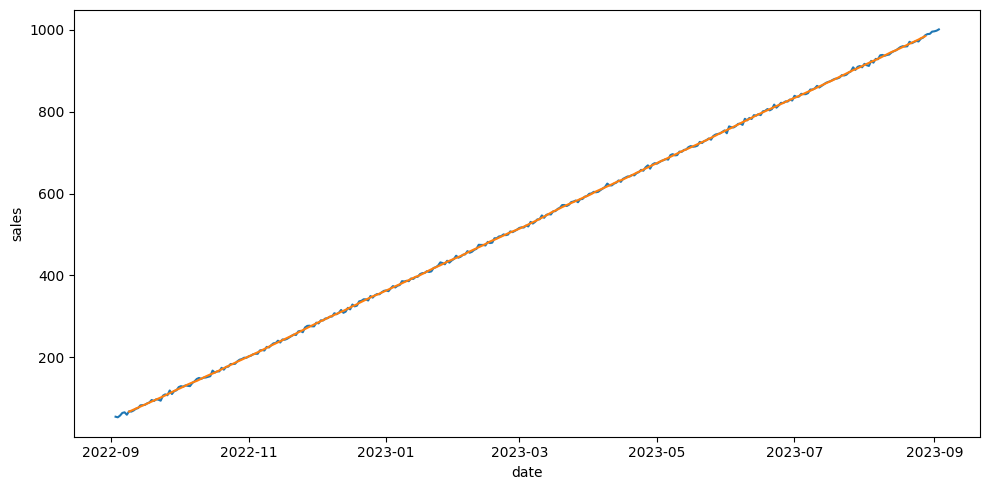

In [20]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

#### Análisis de la estacionalidad

La estacionalidad se refiere a los patrones repetitivos en los datos. Para acceder a su información recurrimos al componente `seasonal` del resultado `decomposition`.

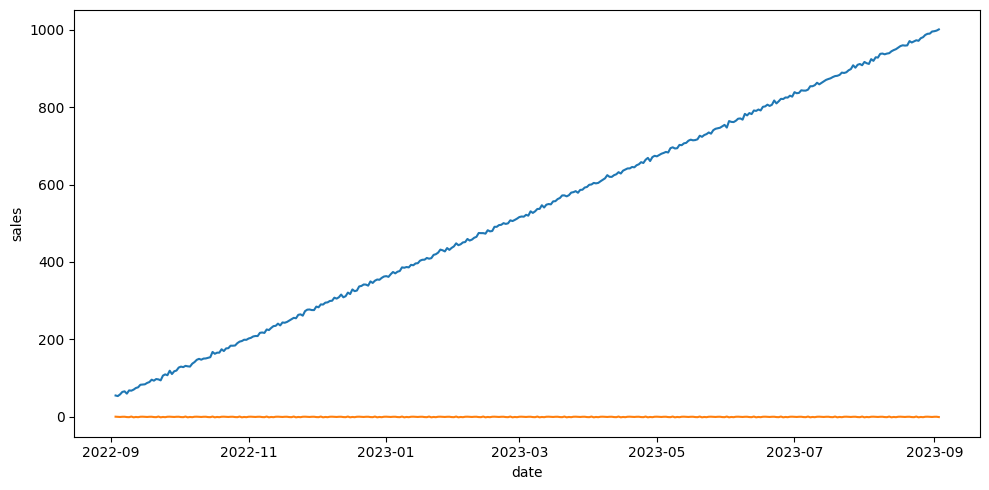

In [21]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Para evaluar la estacionalidad de la serie temporal podemos aplicar la llamada **Prueba de Dickey-Fuller** (*Dickey-Fuller test*), que es un contraste de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa, que es no estacionaria:

In [22]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


,0
Test Statistic,0.545414
p-value,0.986190
#Lags Used,13.000000
Number of Observations Used,352.000000
Critical Value (1%),-3.449065
Critical Value (5%),-2.869786
Critical Value (10%),-2.571163


Aquí podemos ver que el `p-value` es mayor a 0.05, esto significa que nuestra hipótesis nula será rechazada y tomaremos esta serie como no estacionaria.

#### Análisis de la variabilidad

La variabilidad implica el estudio de los residuos: que es cómo fluctúan los datos una vez se ha estudiado la tendencia y la estacionalidad. Para acceder a su información recurrimos al componente `resid` del resultado `decomposition`.

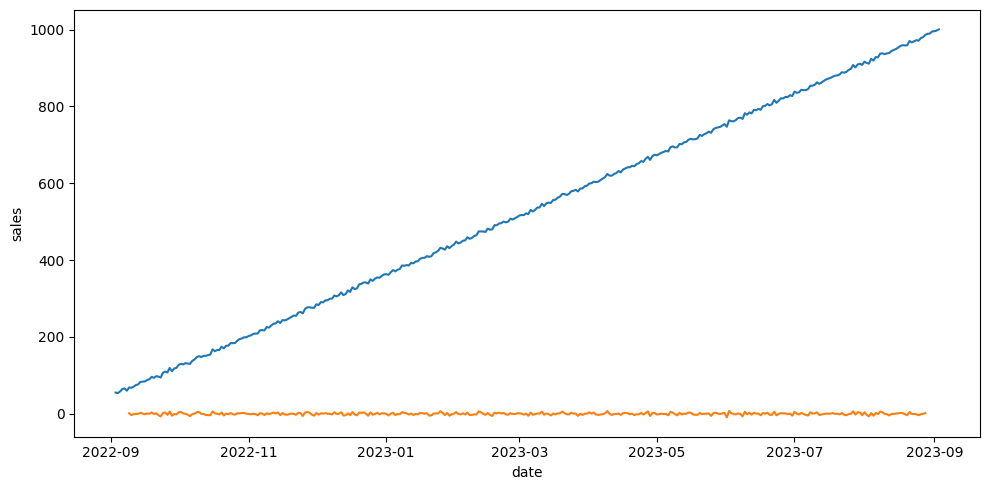

In [23]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Se confirma en parte lo observado, ya que la carga de residuos se hace más notable al inicio y al final del periodo estudiado.

#### Análisis de la autocorrelación

 La autocorrelación es la correlación de una serie de tiempo con una copia retrasada de sí misma. Este gráfico nos ayuda a ver si los valores en la serie de tiempo están correlacionados con los valores anteriores.

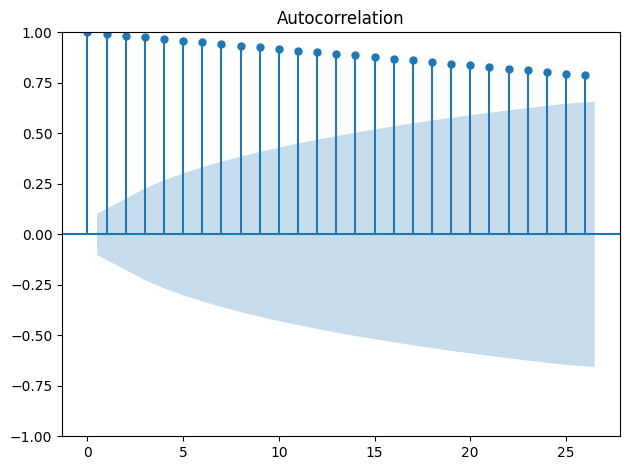

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()

plt.show()

### Paso 3: Entrenamiento del modelo

Un modelo $ARIMA(p, d, q)$ consta de tres hiperparámetros:

- `p`: El orden del componente autorregresivo (AR).
- `d`: El grado de diferenciación necesario para que la serie de tiempo se vuelva estacionaria. Este parámetro es la clave del modelo para manejar series no estacionarias.
- `q`: El orden del componente de media móvil (MA).

El modelo ARIMA está diseñado para trabajar con series de tiempo no estacionarias, ya que el parámetro d se encarga de las transformaciones (diferenciaciones) necesarias para lograr la estacionariedad. No es necesario que la serie esté ya transformada, aunque el análisis preliminar puede ayudar a determinar el valor óptimo de d.

In [ ]:
test_stationarity(ts)


Como la serie no es estacionaria, usaremos la función auto_arima para que encuentre por sí misma los parámetros óptimos, incluyendo las diferenciaciones necesarias (parámetros d y D).

In [25]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 11.9 MB/s eta 0:00:00


In [26]:
from pmdarima import auto_arima

model = auto_arima(ts, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1847.126, Time=6.11 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1972.853, Time=0.82 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2209.657, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1844.668, Time=1.89 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1843.162, Time=0.89 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=2.45 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1843.586, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1841.532, Time=0.71 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1843.435, Time=3.02 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=4.05 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1839.552, Time=0.38 sec
 ARIMA(1,1,1)(1,0,0)[12] inte

Como podemos ver, la función hace una búsqueda en el espacio de soluciones posible para estimar los mejores parámetros. En este caso tendríamos un $ARIMA(1, 1, 1)$. El modelo que devuelve esta función es totalmente usable, como cualquier otro que hayamos visto, y su función `summary()` devuelve información estadística y sobre su rendimiento que tiene gran valor:

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Thu, 22 Jan 2026   AIC                           1839.552
Time:                        03:09:33   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Paso 3: Predicción del modelo

Una vez se ha entrenado el modelo, se puede utilizar para predecir a futuro (predeciremos los siguientes `10` meses)

In [28]:
forecast = model.predict(10)
forecast

,0
2023-09-04,1002.158148
2023-09-05,1004.831668
2023-09-06,1007.423289
2023-09-07,1010.021630
2023-09-08,1012.619419
2023-09-09,1015.217253
2023-09-10,1017.815084
2023-09-11,1020.412915
2023-09-12,1023.010746
2023-09-13,1025.608577


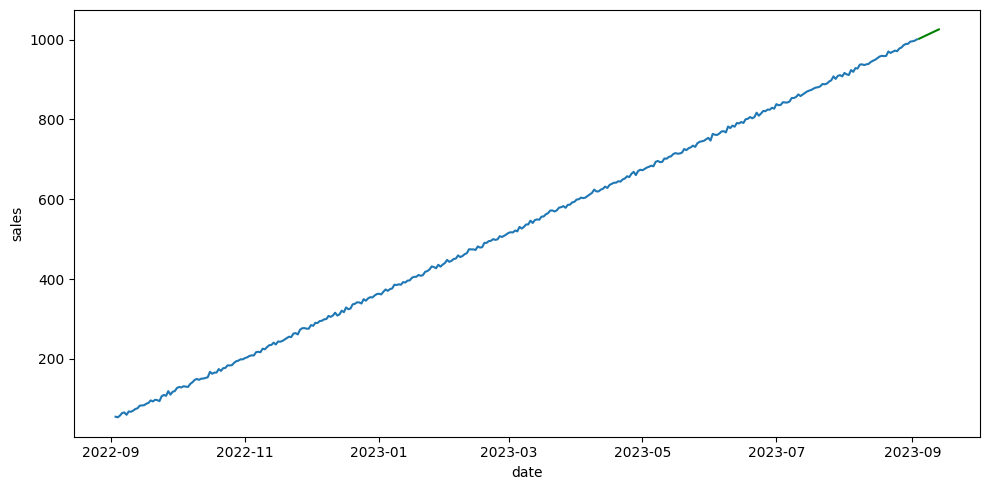

In [30]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

Ahora nuestro modelo es capaz de realizar predicciones a futuro sobre nuestra serie estacionaria.